### 1. Convert image to matrix 

First, convert RGB image to grayscale image using `rgb2gray()` from scikit image. The resulting image is in grayscale in which each pixel is represented with an integer ranged from 0(black) to 255(white).  

In [30]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


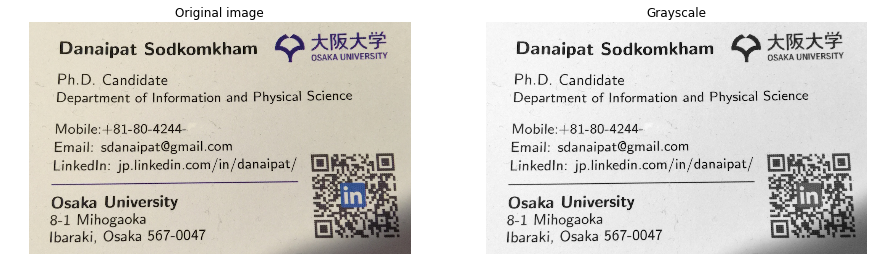

In [200]:
from skimage import io
from skimage.color import rgb2gray


original_img = io.imread('../data/card.jpg')

gray_scale_img = rgb2gray(original_img)
gray_scale_img /= gray_scale_img.max()
gray_scale_img *= 255

plt.gcf().set_size_inches(15, 10)
plt.subplot(121)
plt.axis('off')
plt.imshow(original_img)
plt.title("Original image")

plt.subplot(122)
plt.axis('off')
plt.imshow(gray_scale_img, cmap=plt.cm.gray)
plt.title("Grayscale")

Then we need set a threshold to identify the content (black pixels) from background (white pixels). Finding a proper global threshold of pixel-intensity becomes a bit more complicated when there is variation of pixel-intensity in the background, e.g. shadow in the corner of the picture. The example below shows the results of binarization using global threshold and adaptive threshold, which works around the shadow in the background better than the global thresholding approach. 

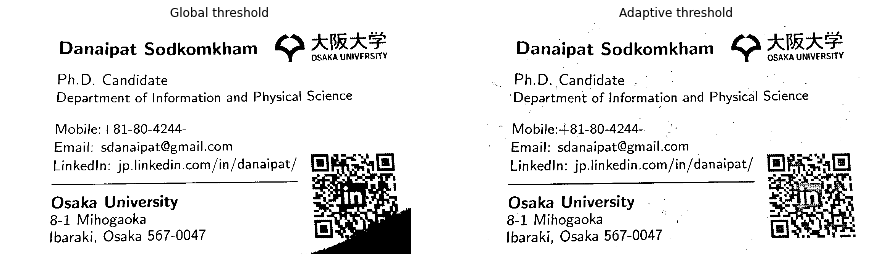

In [205]:
from skimage.filters import threshold_otsu
from skimage.filters import threshold_adaptive

global_thres = threshold_otsu(gray_scale_img)
binarized_global_img = gray_scale_img > global_thres

binarized_adaptive_img = threshold_adaptive(gray_scale_img, block_size=40, offset=20)

plt.gcf().set_size_inches(15, 10)
plt.subplot(121)
plt.axis('off')
plt.imshow(binarized_global_img, cmap=plt.cm.gray)
plt.title("Global threshold")

plt.subplot(122)
plt.axis('off')
plt.imshow(binarized_adaptive_img, cmap=plt.cm.gray)
plt.title("Adaptive threshold")

### 2. Expand each pixel sideway to connect all the characters on the same line or segments

In this step, we want to connect characters that are on the same line or belong to the same word so that each segment of pixels block represents one text segment (a word or a phrase). To do so, we dilate each pixel sideway with a rectangle mask of size 1 x 15 pixels (h x w).

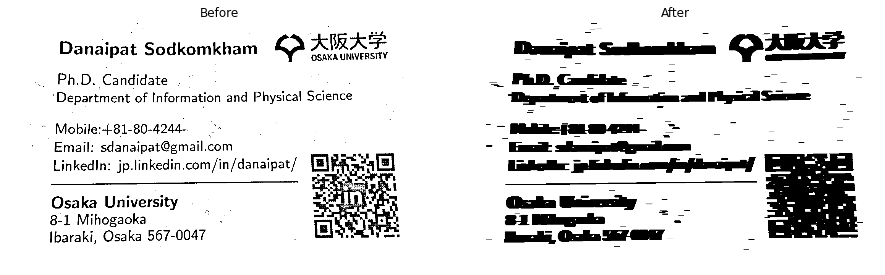

In [206]:
from skimage.morphology import dilation
from skimage.morphology import rectangle

dilated = dilation(~binarized_adaptive_img, rectangle(1, 15))
plt.gcf().set_size_inches(15, 10)

plt.subplot(121)
plt.axis('off')
plt.imshow(binarized_adaptive_img, cmap=plt.cm.gray)
plt.title("Before")

plt.subplot(122)
plt.axis('off')
plt.imshow(~dilated, cmap=plt.cm.gray)
plt.title("After")

### 3. Find the smallest rectangle that covers each segment of connected characters.

One simple way to find connected blocks of pixels is by running DFS to find the top left and bottom right of the rectangle segment. 

In [207]:
def segment(img, i, j):
    s = [(i, j)]
    topleft_i, topleft_j, bottomright_i, bottomright_j = i, j, 0, 0
    directions = [[0, 1], [0, -1], [1, 0], [-1, 0]]
    while s:
        i, j = s.pop()
        topleft_i = min(topleft_i, i)
        topleft_j = min(topleft_j, j)
        bottomright_i = max(bottomright_i, i)
        bottomright_j = max(bottomright_j, j)
        img[i, j] = False
        for d in directions:
            ii = i + d[0]
            jj = j + d[1]
            if ii >= 0 and ii < img.shape[0] and jj >= 0 and jj < img.shape[1] and img[ii, jj]:
                s.append((ii, jj))
    return topleft_i, topleft_j, bottomright_i, bottomright_j


def extract_segments(img):
    segments = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j]:
                segments.append(segment(img, i, j))
    return np.array(segments)
            
        

In [208]:
%time segments = extract_segments(dilated.copy())

CPU times: user 1.35 s, sys: 9.13 ms, total: 1.35 s
Wall time: 1.37 s


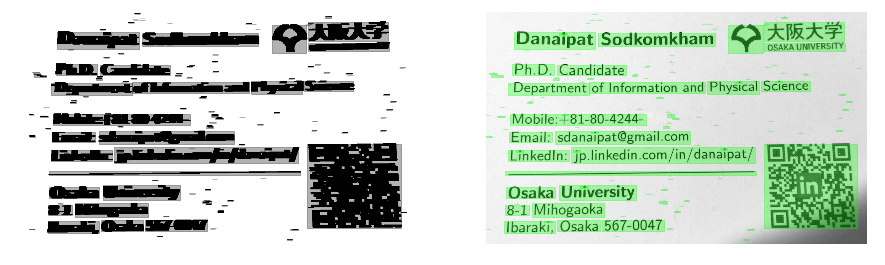

In [209]:
plt.gcf().set_size_inches(15, 10)

plt.subplot(121)
plt.axis('off')
plt.imshow(~dilated, cmap=plt.cm.gray)
ax = plt.gca()
for s in segments:
    ax.add_patch(matplotlib.patches.Rectangle((s[1], s[0]), s[3] - s[1], s[2] - s[0], color=(0, 0, 0, 0.3)))
    
plt.subplot(122)
plt.axis('off')
plt.imshow(gray_scale_img, cmap=plt.cm.gray)
ax = plt.gca()
for s in segments:
    ax.add_patch(matplotlib.patches.Rectangle((s[1], s[0]), s[3] - s[1], s[2] - s[0], color=(0, 1, 0, 0.3)))

As a result, we have extracted segments of texts, university logo, QR code and dusts. Here we are only interested in text segments; therefore, we are required to remove all other segments. From observation, the easiest thing to remove are dusts and QR code segments because their average heights are different from the average height of text segments, which is quite uniform in this case. We can easily group each type of segments by their heights usign Kmeans clustering. In this case, `k=3` seems like a proper choice of number of clusters.

In [210]:
def height(segment):
    return segment[2] - segment[0]

In [211]:
from sklearn.cluster import KMeans

h = np.array([[height(s)] for s in segments])
cluster_labels = KMeans(3).fit_predict(h)

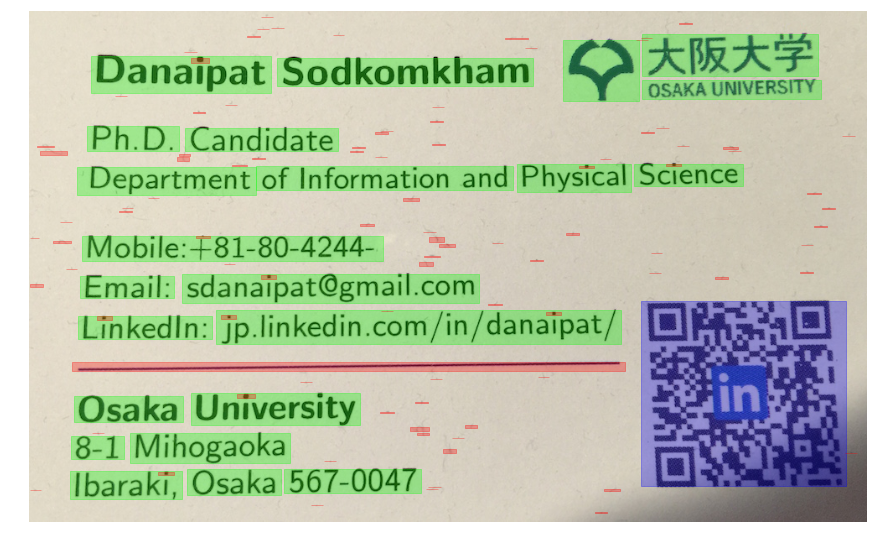

In [212]:
plt.gcf().set_size_inches(15, 10)
plt.axis('off')
plt.imshow(original_img, cmap=plt.cm.gray)
ax = plt.gca()

for i, s in enumerate(segments):
    r = 1 if cluster_labels[i] == 0 else 0
    g = 1 if cluster_labels[i] == 2 else 0
    b = 1 if cluster_labels[i] == 1 else 0
    ax.add_patch(matplotlib.patches.Rectangle((s[1], s[0]), s[3] - s[1], s[2] - s[0], color=(r, g, b, 0.3)))

The result looks quite promissing. We have separated all text segments from dusts and QR code but the university logo  is still included. An alternative solution to this problem is a as follows. 

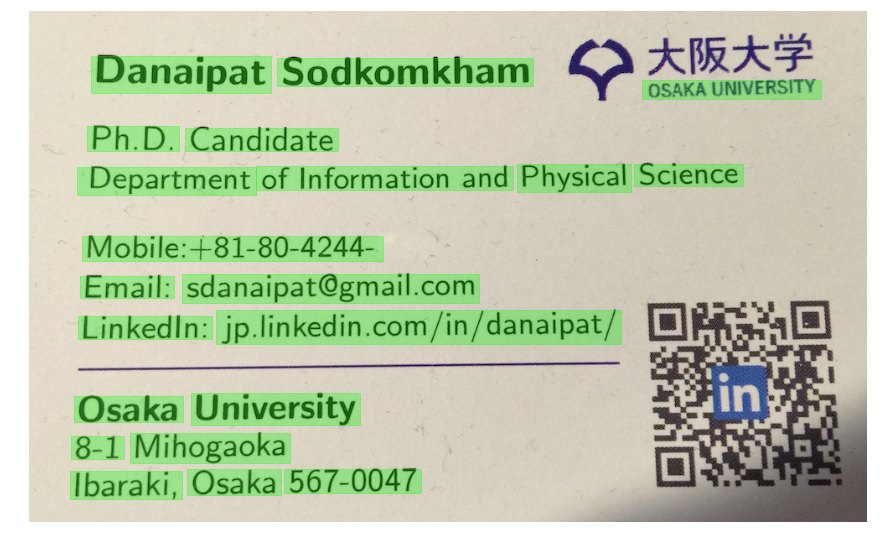

In [215]:
plt.gcf().set_size_inches(15, 10)
plt.axis('off')
plt.imshow(original_img, cmap=plt.cm.gray)
ax = plt.gca()

for s in segments:
    if 20 < height(s) < 50:
        ax.add_patch(matplotlib.patches.Rectangle((s[1], s[0]), s[3] - s[1], s[2] - s[0], color=(0, 1, 0, 0.3)))

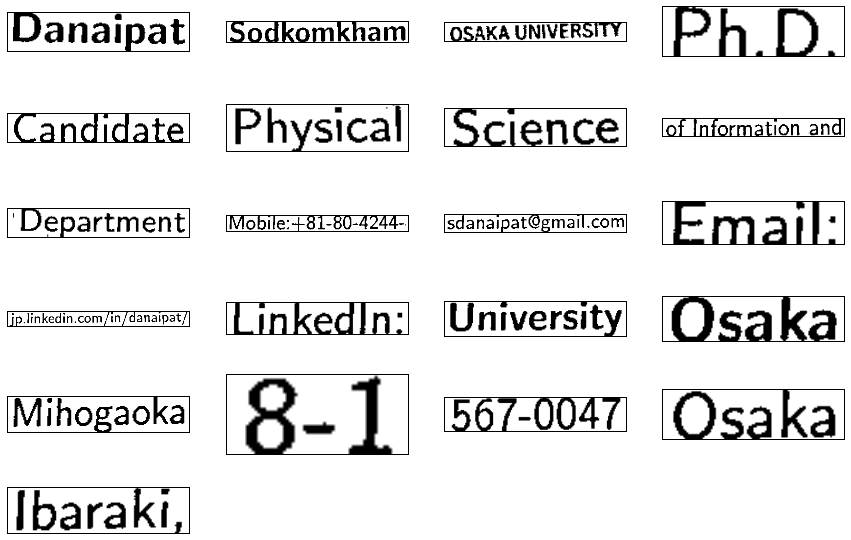

In [186]:
plt.gcf().set_size_inches(15, 10)

segs = []
for i, s in enumerate(segments):
    if 20 < height(s) < 50:
        segs.append(binarized_img[s[0]:s[2], s[1]:s[3]])


for i, s in enumerate(segs):
    plt.subplot(len(segs)/4+1, 4, i + 1)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.imshow(s, cmap=plt.cm.gray)

Another example,

In [231]:
%%time 
original_img = io.imread('../data/nhk.jpg')
gray_scale_img = rgb2gray(original_img)
gray_scale_img /= gray_scale_img.max()
gray_scale_img *= 255
binary_img = threshold_adaptive(gray_scale_img, block_size=40, offset=20)
dilated_img = dilation(~binary_img, rectangle(1, 15))
segments = extract_segments(dilated_img.copy())

CPU times: user 1.43 s, sys: 55.3 ms, total: 1.49 s
Wall time: 1.46 s


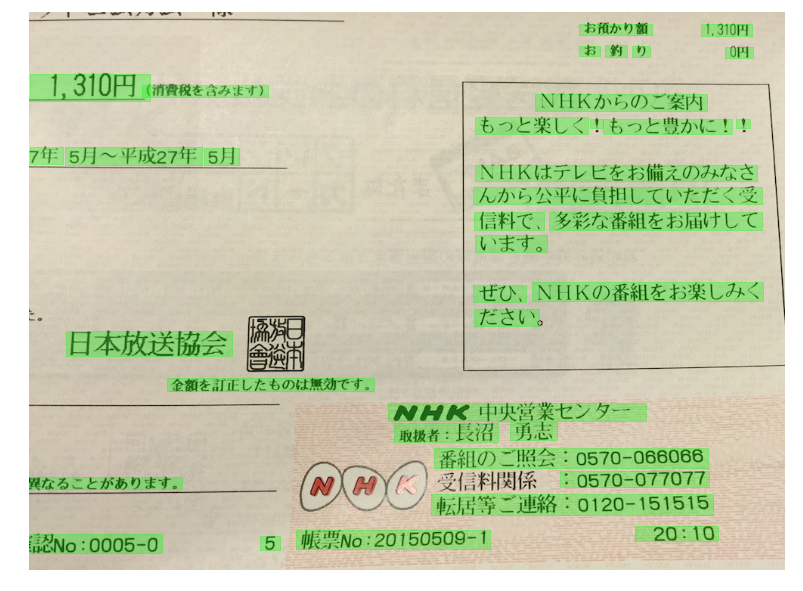

In [233]:
plt.gcf().set_size_inches(15, 10)
plt.axis('off')
plt.imshow(original_img, cmap=plt.cm.gray)
ax = plt.gca()

for s in segments:
    if 10 < height(s) < 50:
        ax.add_patch(matplotlib.patches.Rectangle((s[1], s[0]), s[3] - s[1], s[2] - s[0], color=(0, 1, 0, 0.3)))

In [17]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()